In [2]:
%matplotlib inline
from pylab import *
# import cv2
import rasterio as rio

rcParams['figure.figsize'] = 10, 10

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 14}

matplotlib.rc('font', **font)

import glob
import os,sys
from matplotlib import pyplot as plt
import numpy as np
from scipy import misc
import fiona
from shapely.geometry import shape
import shapely
from rasterio.mask import mask
from pyproj import Proj, transform

import rasterio
from gbdxtools import CatalogImage

# add the unet helpers
sys.path.append('../')
from test_unet_helpers import *

C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\gbdxtools\images\meta.py:21: UserWarning: ShareDict has been deprecated in favor of HighLevelGraph and will be removed in future versions
  from dask import sharedict, optimization


In [3]:
# specify scene id for DG data
dg_scene_id = '1030010057062200'


# specify image for 2.0 meter analysis
gt_image_2 = '../rasters/union_impervious_raster_2_0_0_wgs84.tif' # aws
gt_image_2 = '../../../smart_cities/Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0_wgs84.tif' # desktop

# specify images for 0.5 meter analysis
gt_image_05 = '../rasters/union_impervious_raster_0_5.tif' # aws

# specify the shapefile
shpfile = '../union/union.shp' # aws
shpfile = '../../../smart_cities/Denver_Sample_Sites/union/union.shp' # desktop
rows = []
with fiona.open(shpfile) as shp:
    crs = shp.crs
    shp_bounds = shp.bounds
    
# generate the sample points
# we have some funny stuff from ArcGIS converting the polygons to a raster... so... 
# generate the points within the bounds of the shapefile / DG image array

In [35]:
coords = np.loadtxt(r"D:\projects\RD\debug_IS_segmentation\image_coords_256x256.txt")
lonlat_MS = np.loadtxt(r"D:\projects\RD\debug_IS_segmentation\lonlat_MS_coords_256x256.txt")

# Plot the points


In [16]:
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point
from fiona.crs import from_epsg

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

In [36]:
# geodataframe for the points
pt_frame = gpd.GeoDataFrame({'geometry': [Point(p) for p in lonlat_MS]})
pt_frame.crs = from_epsg(4326)

# geodata frame for the boundary
boundary = gpd.read_file(shpfile)


In [37]:
# divide into training, test, and validation points
from sklearn.model_selection import train_test_split

seed=10
train_pts, hold_pts = train_test_split(pt_frame, train_size=0.6, test_size=0.4, random_state=seed)
test_pts, val_pts = train_test_split(hold_pts, train_size=0.5, test_size=0.5, random_state=seed)

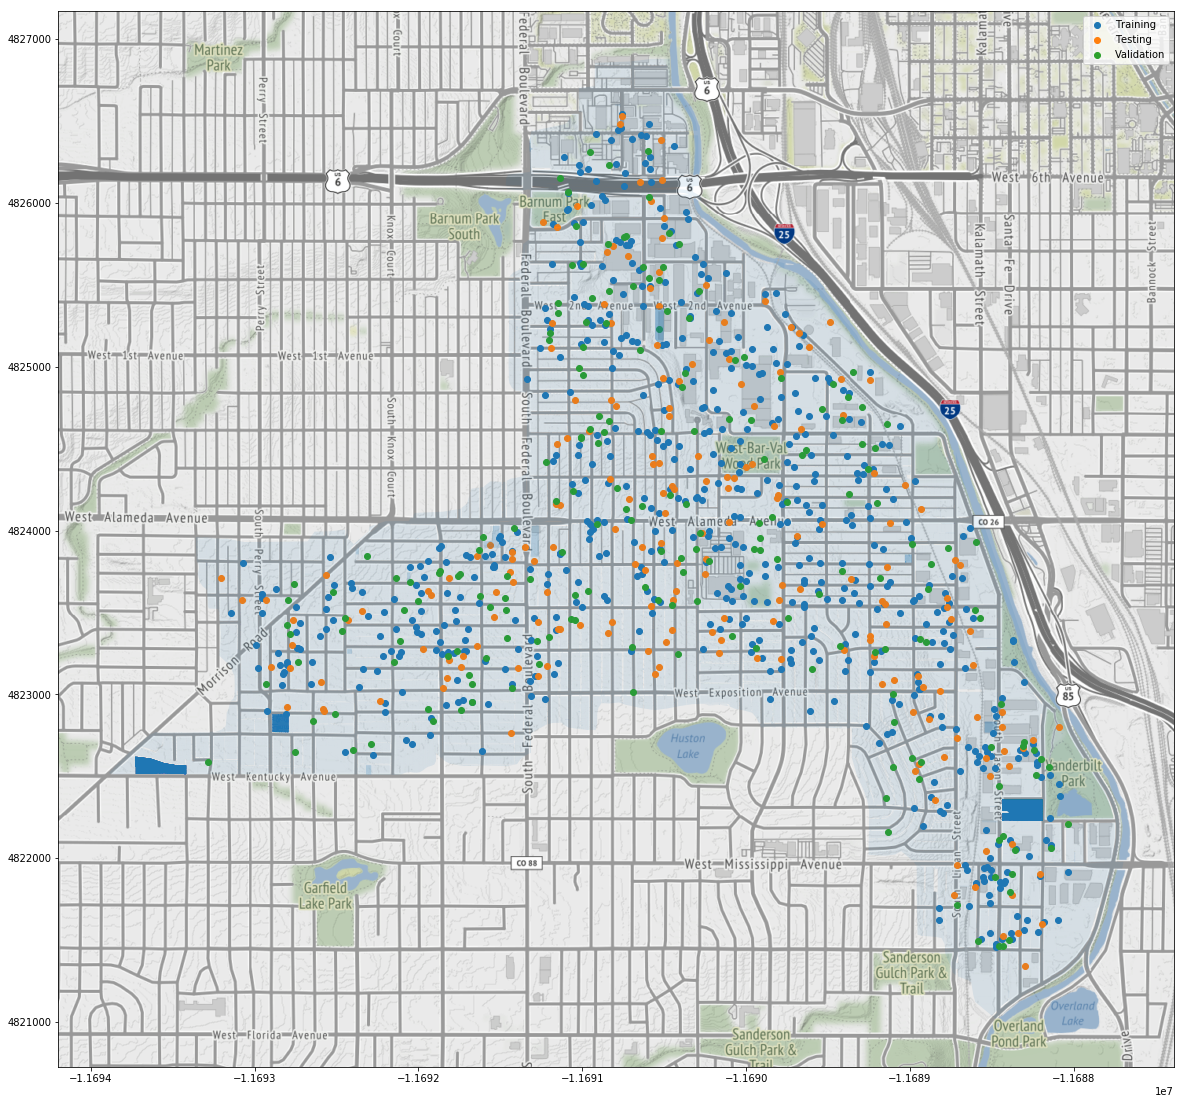

In [38]:
# plot
ax = train_pts.to_crs(epsg=3857).plot(figsize=(20,20), label='Training')
test_pts.to_crs(epsg=3857).plot(ax=ax, label='Testing')
val_pts.to_crs(epsg=3857).plot(ax=ax, label='Validation')
boundary.to_crs(epsg=3857).plot(alpha=0.1, ax=ax)
add_basemap(ax, zoom=15)
plt.legend()